In [58]:
Z_DIM = 3

### 1. Load dataset

In [59]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time


import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)


In [60]:
import os

In [61]:
class Synthetic(Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)
        imgs = [i for i in imgs if i != '.DS_Store']

        self.dataset = dataset

        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5, 0), (0.5, 0.5, 0.5, 1))])
    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        if self.transforms:
            data = self.transforms(pil_img)[:3]
        else:
            pil_img = np.asarray(pil_img)[:, :, :3].reshape(96, 96, 3)
            data = torch.from_numpy(pil_img)
        ret = {
            'img': data,
            'label': label,
        }
        return ret

    def __len__(self):
        return len(self.imgs)

In [62]:
dataset_dir = '../../data/pendulum/pendulum'
train_dataset = Synthetic(dataset_dir, "train")
test_dataset = Synthetic(dataset_dir, "test")
cf_dataset = Synthetic(dataset_dir, "cf")
train_dataset[0]['img'].shape

torch.Size([3, 96, 96])

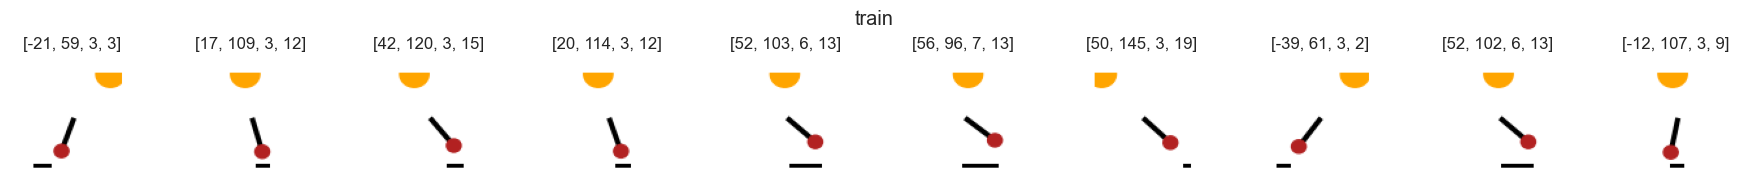

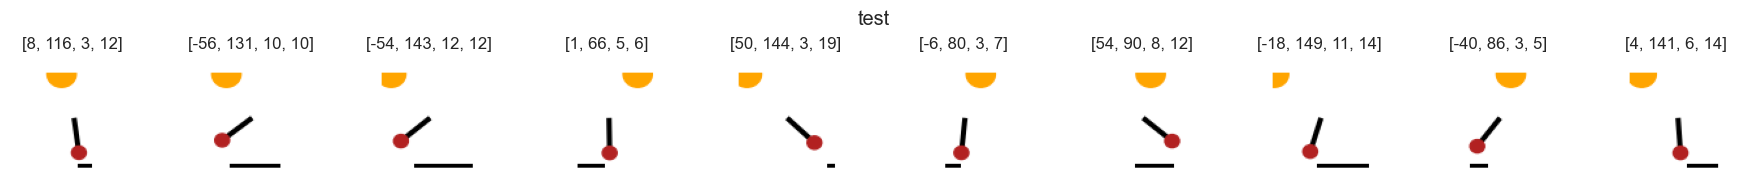

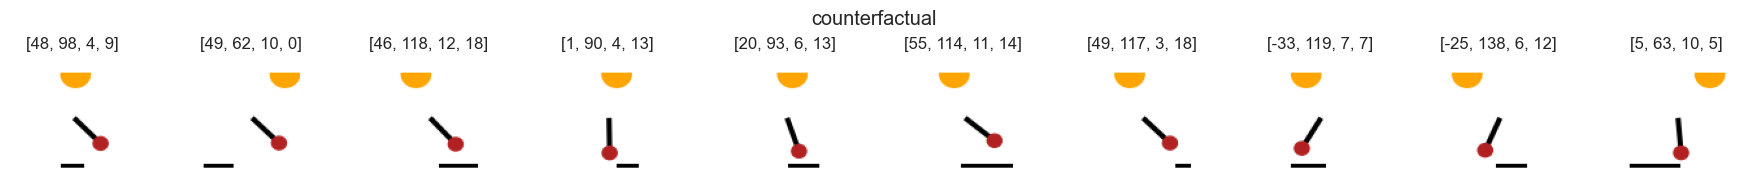

In [63]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [train_dataset, test_dataset, cf_dataset]):
    plt.figure(figsize=(18, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label'].tolist()))
        plt.axis('off')
    plt.suptitle(n, y=.95)
    plt.tight_layout()

In [64]:
BS = 256
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True) #, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
cf_loader = DataLoader(cf_dataset, batch_size=BS, shuffle=False)

### 2. Build CVAE

In [65]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3456 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3456 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=96*6*6)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.Upsample((12, 12)),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.Upsample((24, 24)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((48, 48)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.Upsample((96, 96)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.first_layer(z).view((-1, 96, 6, 6))
        return self.upsampling_layers(x)

In [66]:
class CVAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, labels], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(torch.cat([z, labels], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Train CVAE

In [67]:
def plot_image(x):
    plt.figure(figsize=(3, 3))
    plt.imshow(normalize(x.cpu()))
    plt.axis('off')

def plot_img_on_ax(x, ax):
    ax.imshow(normalize(x.cpu()))
    ax.axis('off')

def show_reconstructions(vae, loader, cols=5, rows=1, title=''):
    for k, batch in enumerate(loader):
        if k >= rows:
            return
        x = batch['img']
        l = batch['label']
        plt.figure(figsize=(1.5 * cols, 3))
        for i in range(cols):
            plt.subplot(2, cols, i+1)
            plt.imshow(normalize(x[i].permute(1, 2, 0)))
            plt.axis('off')
            plt.subplot(2, cols, i+cols+1)
            rec_img = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy().transpose((1, 2, 0))
            plt.imshow(normalize(rec_img))
            plt.axis('off')
        plt.suptitle(title, y=.9)
        plt.tight_layout()

def run_epoch(svi, dataloader, use_cuda=False):
    epoch_loss = 0.
    for batch in dataloader:
        epoch_loss += svi.step(batch['img'], batch['label'])
    return epoch_loss / len(dataloader.dataset)

def callback(train_elbo, test_elbo, test_epoch_num, epoch, vae):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    plt.plot(test_epoch_num, test_elbo, lw=2, color='#FF3300', label='test')
    plt.legend()
    plt.xlabel('epoch')
    plt.title(f'Epoch {epoch}. ELBO {test_elbo[-1]}')
    plt.show()
    vae.train(False);
    show_reconstructions(vae, cf_loader, 4, 1, title='counterfactual')
    show_reconstructions(vae, test_loader, 4, 1, title='test')
    vae.train(True);
    plt.show()

LEARNING_RATE = 5.0e-4
USE_CUDA = torch.cuda.is_available()
pyro.clear_param_store()
adam_args = {"lr": LEARNING_RATE}

### 3.1 CVAE Sanity Checks

In [68]:
pyro.clear_param_store()
vae = CVAE(z_dim=Z_DIM, p=0.1, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('vae_06_08_exp2.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae.train(False);

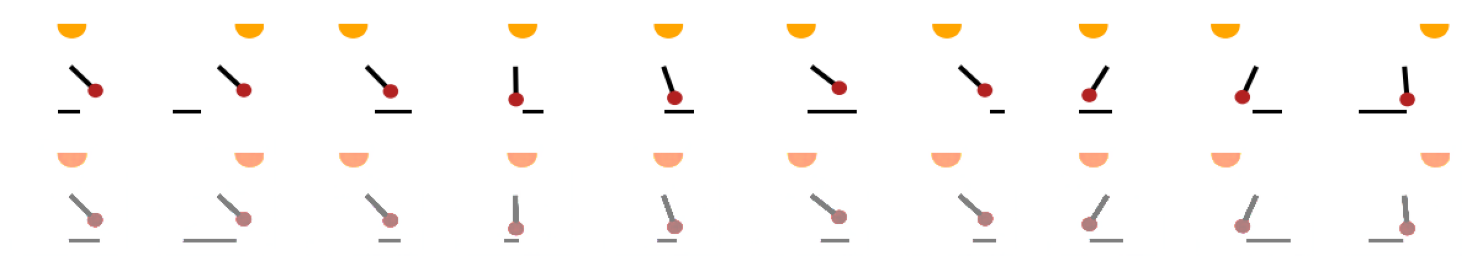

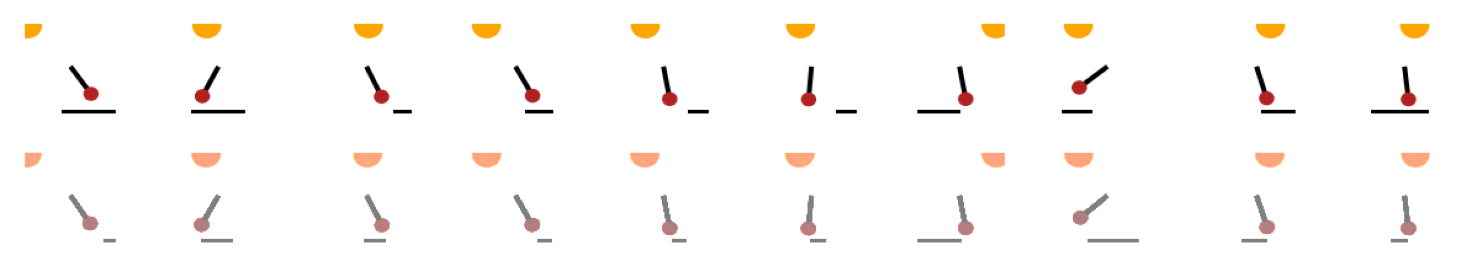

In [69]:
show_reconstructions(vae, cf_loader, 10, 2);

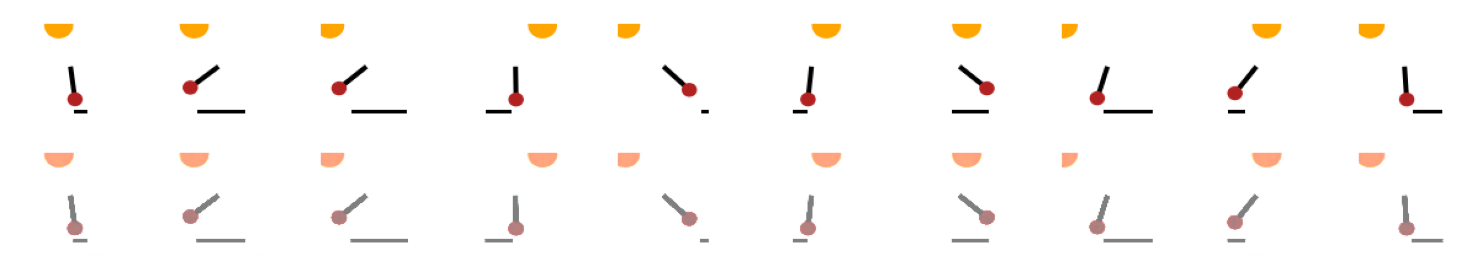

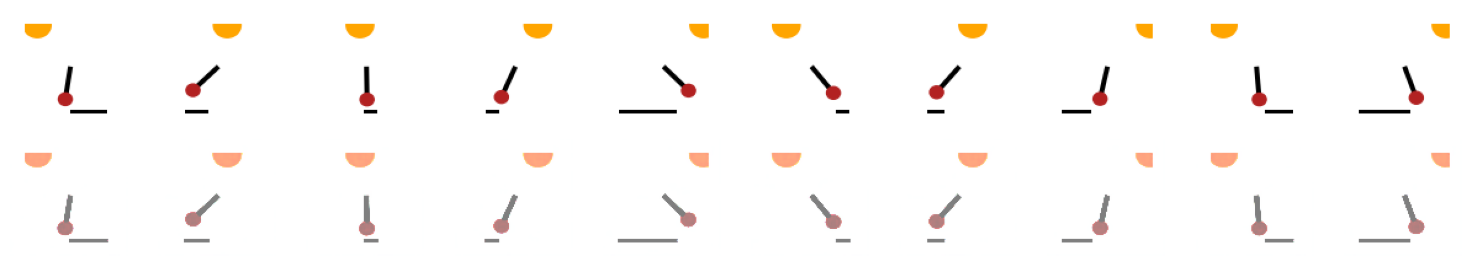

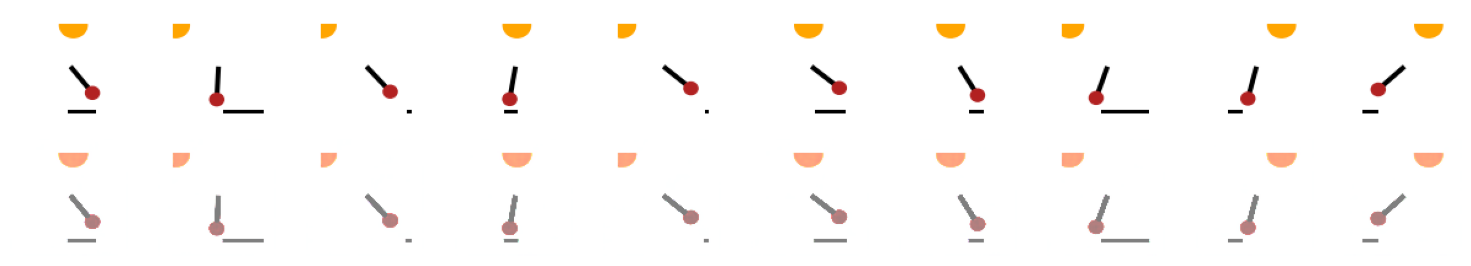

In [70]:
show_reconstructions(vae, test_loader, 10, 3);

### 4. Metric

In [71]:
NUM_PER_COMB = 4

In [72]:
import math

def projection(theta, phi, x, y, base=-0.5):
    b = y - x * np.tan(phi)
    shade = (base - b) / np.tan(phi)
    return shade

def get_true_shade(i, j):
    theta = i * math.pi / 200.0
    phi = j * math.pi / 200.0
    ball_x = 10 + 9.5 * np.sin(theta)
    ball_y = 10.5 - 9.5 * np.cos(theta)
    true_shade = np.maximum(3, np.abs(projection(theta, phi, 10.0, 10.5) - projection(theta, phi, ball_x, ball_y)))
    true_mid = (projection(theta, phi, 10.0, 10.5) + projection(theta, phi, ball_x, ball_y)) / 2
    return true_shade, true_mid

In [73]:
def crude_generate(vae, ys, z_dim=Z_DIM, BS=NUM_PER_COMB, sigma_=0.1):
    if ys[2] is None:
        ys[2], ys[3] = get_true_shade(*ys[:2])
    z_loc = torch.zeros(z_dim)
    z_scale = torch.ones(z_dim) * sigma_
    z = dist.Normal(z_loc, z_scale).sample((BS,))
    loc_img = vae.decoder(z, torch.tensor([ys] * BS).float()).detach()
    return loc_img

def show_pictures(loc_img):
    BS = len(loc_img)
    f, ax = plt.subplots(1, BS, figsize=(12, 1))
    ax = ax.flatten()
    for i in range(BS):
        ax[i].imshow(normalize(loc_img[i].permute(1, 2, 0)))
        ax[i].axis('off')
    plt.show()

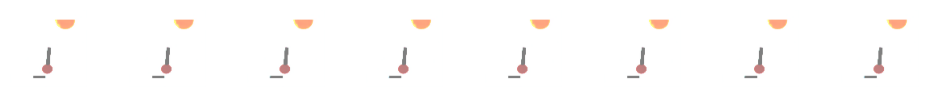

In [74]:
loc_img = crude_generate(vae, [-5, 72, None, None], BS=8)
show_pictures(loc_img)

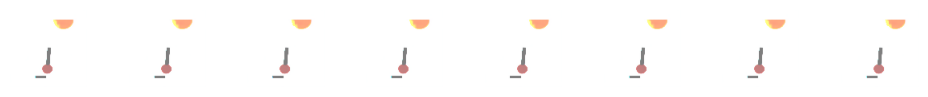

In [75]:
loc_img = crude_generate(vae, [-5, 72, 1, 10], BS=8)
show_pictures(loc_img)

In [76]:
gen_imgs = []
gen_labels = []
cf_imgs = []
cf_labels = []
for i in tqdm(range(-60, 60)):
    for j in range(50, 150):
        if j == 100 or j == 0:
            continue

        # TRUE COMBINATION
        true_shade, true_mid = get_true_shade(i, j)
        ys = [i, j, true_shade, true_mid]
        gen_imgs.append(crude_generate(vae, ys))
        gen_labels.extend([ys] * NUM_PER_COMB)

        # CF COMBINATION
        shade = np.random.randint(3, 14)
        while shade == true_shade:
            shade = np.random.randint(3, 14)
        mid = np.random.randint(-2, 22)
        while mid == true_mid:
            mid = np.random.randint(-2, 22)
        ys = [i, j, shade, mid]
        cf_imgs.append(crude_generate(vae, ys))
        cf_labels.extend([ys] * NUM_PER_COMB)

100%|█████████████████████████████████████████| 120/120 [06:30<00:00,  3.26s/it]


In [77]:
gen_imgs = torch.stack(gen_imgs).flatten(end_dim=1)
cf_imgs = torch.stack(cf_imgs).flatten(end_dim=1)
gen_labels = torch.tensor(gen_labels)
cf_labels = torch.tensor(cf_labels)
gen_imgs.shape, cf_imgs.shape, gen_labels.shape, cf_labels.shape

(torch.Size([47520, 3, 96, 96]),
 torch.Size([47520, 3, 96, 96]),
 torch.Size([47520, 4]),
 torch.Size([47520, 4]))

In [78]:
class DatasetForInference(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        ret = {
            'img': self.imgs[idx],
            'label': self.labels[idx],
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [79]:
train_inf_dataset = DatasetForInference(gen_imgs, gen_labels)
cf_inf_dataset = DatasetForInference(cf_imgs, cf_labels)

BATCH_SIZE = 40
train_inf_loader = DataLoader(train_inf_dataset, batch_size=BATCH_SIZE, shuffle=True)
cf_inf_loader = DataLoader(cf_inf_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
class PendulumRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(PendulumRegressor, self).__init__()
        self.p = 0.4
        self.shade_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 2),
        )
        self.sun_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )
        self.pend_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1960, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        sun, pend, shade = x[:, 1, :24].unsqueeze(1), x[:, 1, 45:80, 20:-20].unsqueeze(1), x[:, 1, 83:85]
        sun_pred = self.sun_net(sun)
        pend_pred = self.pend_net(pend)
        shade_pred = self.shade_net(shade)
        return torch.cat([pend_pred, sun_pred, shade_pred], dim=1)

In [103]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
regressor = PendulumRegressor().to(device)
regressor.load_state_dict(torch.load('../../pendulum_regressor/regressor.pth', map_location='cpu'))

<All keys matched successfully>

In [104]:
def mse(A, B):
    return ((A - B)**2).mean(axis=1)
    
def get_mse(loader):
    with torch.no_grad():
        mses_Y1 = []
        mses_Y2 = []
        for batch in tqdm(loader):
            X_batch = batch['img']
            y_batch = batch['label']
            pred = regressor(X_batch) # (BS, 30)
            mses_Y1.extend(mse(y_batch[:, :2], pred.detach()[:, :2]))
            mses_Y2.extend(mse(y_batch[:, 2:], pred.detach()[:, 2:]))
        return np.stack([mses_Y1, mses_Y2])

In [105]:
mse_train = get_mse(train_inf_loader)
mse_cf = get_mse(cf_inf_loader)

print('\nTRAIN:', mse_train.mean(axis=1))
print('CF:   ', mse_cf.mean(axis=1))

100%|██████████████████████████████████████| 1188/1188 [00:04<00:00, 282.30it/s]



TRAIN: [236.64247728   9.40334312]
CF:    [281.4967    44.200695]


In [99]:
def mse(A, B):
    return ((A - B)**2).mean(axis=1)
    
def get_mse_allfour(loader):
    with torch.no_grad():
        mses_Y11 = []
        mses_Y12 = []
        mses_Y21 = []
        mses_Y22 = []
        for batch in tqdm(loader):
            X_batch = batch['img']
            y_batch = batch['label']
            pred = regressor(X_batch) # (BS, 30)
            mses_Y11.extend(mse(y_batch[:, 0], pred.detach()[:, 0:1]))
            mses_Y12.extend(mse(y_batch[:, 1], pred.detach()[:, 1:2]))
            mses_Y21.extend(mse(y_batch[:, 2], pred.detach()[:, 2:3]))
            mses_Y22.extend(mse(y_batch[:, 3], pred.detach()[:, 3:4]))
        return np.stack([mses_Y11, mses_Y12, mses_Y21, mses_Y22])    

In [89]:
mse_train = get_mse(train_inf_loader)
mse_cf = get_mse(cf_inf_loader)

print('\nTRAIN:', mse_train.mean(axis=1))
print('CF:   ', mse_cf.mean(axis=1))

100%|██████████████████████████████████████| 1188/1188 [00:05<00:00, 208.79it/s]



TRAIN: [1906.34105112 1539.48068935  235.35550948    9.38126702]
CF:    [ 99.524635 647.8433   282.44388   44.351826]


New regressor (V2)

In [93]:
class PendulumRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(PendulumRegressor, self).__init__()
        self.p = 0.4
        self.shade_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 2),
        )
        self.sun_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )
        self.pend_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1960, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        sun = x[:, :, :24].min(axis=1)[0].unsqueeze(1)
        pend = x[:, :, 45:80, 20:-20].min(axis=1)[0].unsqueeze(1)
        shade = x[:, :, 83:85].min(axis=1)[0]
        sun_pred = self.sun_net(sun)
        pend_pred = self.pend_net(pend)
        shade_pred = self.shade_net(shade)
        return torch.cat([pend_pred, sun_pred, shade_pred], dim=1)

In [94]:
regressor = PendulumRegressor().to(device)
regressor.load_state_dict(torch.load('../../pendulum_regressor/regressor_v2.pth', map_location='cpu'))

<All keys matched successfully>

In [96]:
mse_train = get_mse(train_inf_loader)
mse_cf = get_mse(cf_inf_loader)

print('\nTRAIN:', mse_train.mean(axis=1))
print('CF:   ', mse_cf.mean(axis=1))

100%|██████████████████████████████████████| 1188/1188 [00:06<00:00, 186.66it/s]



TRAIN: [1872.26393595 1357.73553233  337.8431458    10.39620288]
CF:    [106.05811 748.6412  366.02695  43.68879]
